[source](https://colab.research.google.com/github/snakers4/silero-vad/blob/master/silero-vad.ipynb#scrollTo=pSifus5IilRp)

https://github.com/snakers4/silero-vad



In [92]:
import torch
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=False)

c:\Users\tzurv\.conda\envs\deepfake\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\tzurv/.cache\torch\hub\master.zip


[example.py](https://github.com/wiseman/py-webrtcvad/blob/master/example.py)

https://hackage.haskell.org/package/webrtc-vad-0.1.0.3/docs/Sound-VAD-WebRTC.html

https://github.com/wiseman/py-webrtcvad/blob/master/test_webrtcvad.py


In [198]:
import numpy as np
import collections
import contextlib
import sys
import wave

import webrtcvad

def concatenate_voiced(segments):
    voiced_audio = None
    for i, segment in enumerate(segments):
        if voiced_audio is None:
            voiced_audio = np.frombuffer(segment.bytes, dtype=np.int16)
        else:
            voiced_audio = np.concatenate((voiced_audio, np.frombuffer(segment.bytes, dtype=np.int16)), axis=None)
    return voiced_audio
        
def read_wave(path):
    """Reads a .wav file.

    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.

    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data.
        bytes is a built-in data type in Python, representing a sequence of bytes
    """
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.

    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.

    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        #print((offset, offset + n), type(audio[offset:offset + n]))
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames,
                  *, 
                  start_voice_threshold=0.6,
                  end_voice_threshold=0.6):
    """Filters out non-voiced audio frames.

    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.

    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.

    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.

    Arguments:

    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).

    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    print(f"{num_padding_frames=}")
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for index, frame in enumerate(frames):
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        #print(index, is_speech)

        sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > start_voice_threshold * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > end_voice_threshold * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                #yield b''.join([f.bytes for f in voiced_frames])
                #audio_data = b''.join([f.bytes for f in voiced_frames])

                yield concatenate_voiced(voiced_frames)
                
                ring_buffer.clear()
                voiced_frames = []

    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        #yield b''.join([f.bytes for f in voiced_frames])
        yield concatenate_voiced(voiced_frames)

def main(args):
    if len(args) != 2:
        sys.stderr.write(
            'Usage: example.py <aggressiveness> <path to wav file>\n')
        sys.exit(1)
    audio, sample_rate = read_wave(args[1])
    vad = webrtcvad.Vad(int(args[0]))
    frames = frame_generator(30, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(sample_rate, 30, 300, vad, frames)
    for i, segment in enumerate(segments):
        path = 'chunk-%002d.wav' % (i,)
        print(' Writing %s' % (path,))
        write_wave(path, segment, sample_rate)


if __name__ == '__main__':
    #main(sys.argv[1:])
    pass

In [211]:
import librosa

audioFile = r"C:\work\Github\Tensor_Lihu\MultiKol\ASVspoof2021_DF_eval_part00\ASVspoof2021_DF_eval\flac\DF_E_2747904.flac"
#audioFile = r"C:\Users\tzurv\Downloads\example.wav"
#audio, sample_rate = read_wave(audioFile)
X, fs = librosa.load(audioFile, sr=16000)
Xint16 = (X * 32767).astype(np.int16)

In [218]:
float32_array = Xint16.astype(np.float32) / 32767.0
print(X[-10:], float32_array[-10:])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [219]:
vad = webrtcvad.Vad(1)
sample_rate = 16000
frames = frame_generator(30, Xint16, sample_rate)
frames = list(frames)
just_audio_segments = []
for voice_part in vad_collector(sample_rate, 30, 150, vad, frames):
    just_audio_segments.append(voice_part)

just_audio = np.concatenate(just_audio_segments)
just_audio = just_audio[int(sample_rate*0.1):]
just_audio_float32 = just_audio.astype(np.float32) / 32767.0


num_padding_frames=5
1111+(0.0)111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111110111111111111111111111-(4.079999999999989)


131072 128960


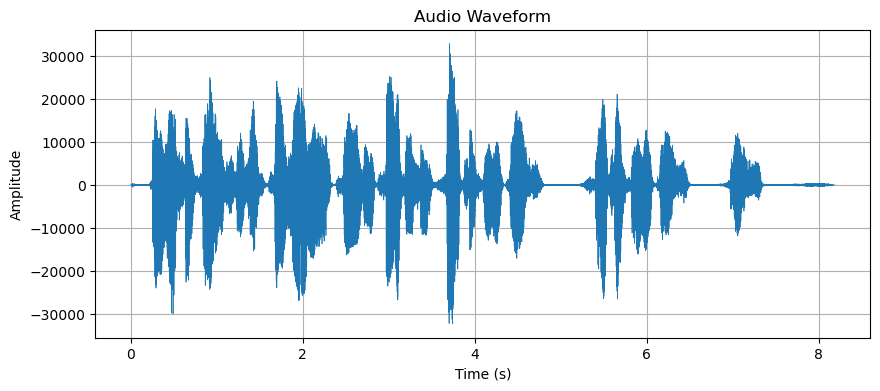

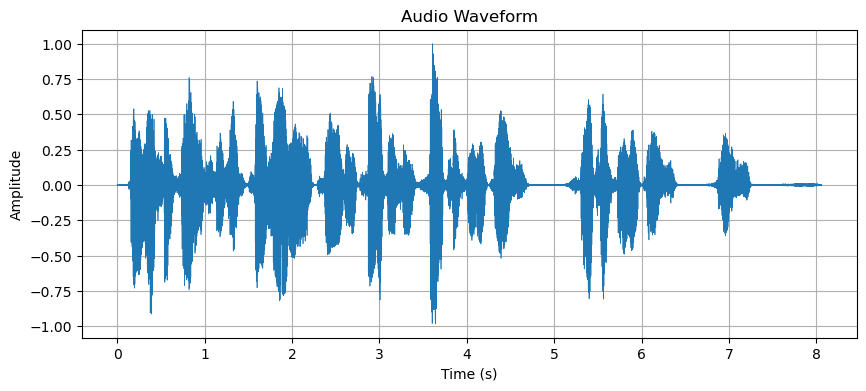

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def plot_audio(audio_np):
    # Load your audio data into a NumPy array (replace this with your data)
    # For example, if X is your audio data:
    # X = np.array(...)  # Replace ... with your audio data

    # Create a time axis based on the length of the audio and the sampling rate
    time = np.arange(0, len(audio_np)) / 16000.0  # Assuming a sampling rate of 16000 Hz

    # Create a plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_np, linewidth=0.5)
    #plt.plot(frame_time[:-1], is_voice_list, linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Waveform')
    plt.grid(True)
    plt.show()

print(len(Xint16), len(just_audio))
plot_audio(Xint16)
plot_audio(just_audio_float32)


In [ ]:
vad = webrtcvad.Vad(0)
sample_rate = 16000
frame_duration_ms = 30
frame_time = [frame_duration_ms/1000*2]
frames = frame_generator(frame_duration_ms, Xint16, sample_rate)
frames = list(frames)
is_voice_list = []
for index, frame in enumerate(frames):
    is_speech = vad.is_speech(frame.bytes, sample_rate)
    is_voice_list.append(5000 if is_speech else 0)
    frame_time.append(frame_time[-1] + frame_duration_ms/1000*2)
#    print(index, is_speech)
#print(frame_time)
#print(len(frames))
#print(len(Xint16))

#### upto here ############

In [ ]:
vad = webrtcvad.Vad(1)
sample_rate = 16000
frames = frame_generator(10, X, sample_rate)
frames = list(frames)
print(len(frames))
voiced_audio_frames = vad_collector(sample_rate, 30, 300, vad, frames)


In [45]:
import numpy as np

# Assuming you have a Frame instance named 'frame'
audio_data_bytes = voiced_audio[0].bytes
audio_data_np = np.frombuffer(audio_data_bytes, dtype=np.float32)


In [51]:
voiced_audio = None
for i, segment in enumerate(voiced_audio_frames):
    if voiced_audio is None:
        voiced_audio = np.frombuffer(segment.bytes, dtype=np.float32)
    else:
        voiced_audio = np.concatenate((voiced_audio, np.frombuffer(segment.bytes, dtype=np.float32)), axis=None)



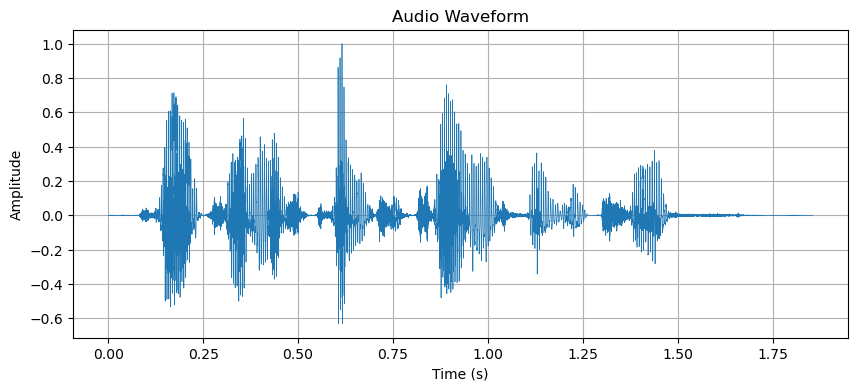

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Load your audio data into a NumPy array (replace this with your data)
# For example, if X is your audio data:
# X = np.array(...)  # Replace ... with your audio data

# Create a time axis based on the length of the audio and the sampling rate
time = np.arange(0, len(X)) / 16000.0  # Assuming a sampling rate of 16000 Hz

# Create a plot
plt.figure(figsize=(10, 4))
plt.plot(time, X, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid(True)
plt.show()

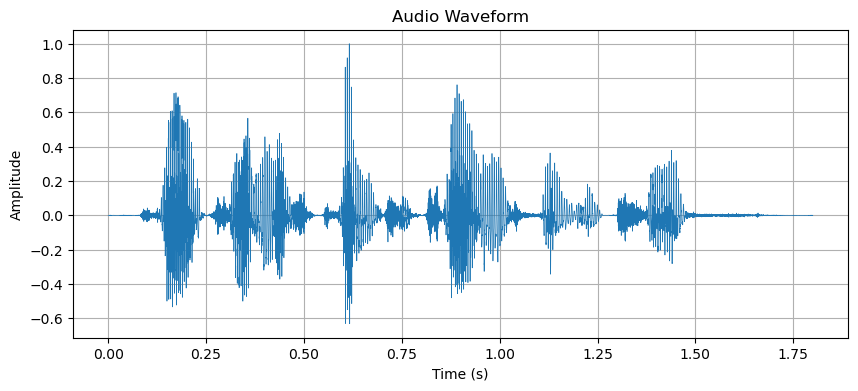

In [56]:
# Create a time axis based on the length of the audio and the sampling rate
time = np.arange(0, len(voiced_audio)) / 16000.0  # Assuming a sampling rate of 16000 Hz

# Create a plot
plt.figure(figsize=(10, 4))
plt.plot(time, voiced_audio, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid(True)
plt.show()